<a href="https://colab.research.google.com/github/dahlia52/ESAA_2022-2/blob/main/Keras_CNN_Dog_or_Cat_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/uysimty/keras-cnn-dog-or-cat-classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("/content/drive/MyDrive/Data/캐글 실습 필사"))

['drug200.csv', 'House Prices', 'Titanic', 'Mall_Customers.csv', 'fasttext', 'mercari_train.tsv', 'test_500.zip', 'test_500', 'train_700']


## Define Constants

In [ ]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## Prepare Traning Data

In [ ]:
filenames = os.listdir("/content/drive/MyDrive/Data/캐글 실습 필사/train_700")
categories = []

for filename in filenames:
  category = filename.split('.')[0]
  if category == 'dog':
    categories.append(1)
  else:
    categories.append(0)

df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [ ]:
df.head()

,filename,category
0,dog.460.jpg,1
1,dog.465.jpg,1
2,dog.461.jpg,1
3,dog.464.jpg,1
4,dog.466.jpg,1


In [ ]:
df.tail()

,filename,category
1397,dog.459.jpg,1
1398,dog.46.jpg,1
1399,dog.455.jpg,1
1400,dog.456.jpg,1
1401,dog.458.jpg,1


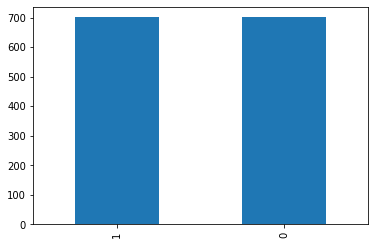

In [ ]:
df['category'].value_counts().plot.bar()
# 강아지, 고양이 각각 12000장

## See sample image

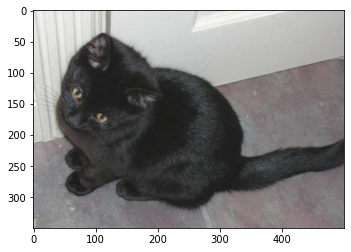

In [ ]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/Data/캐글 실습 필사/train_700/" + sample)
plt.imshow(image)

## Build Model

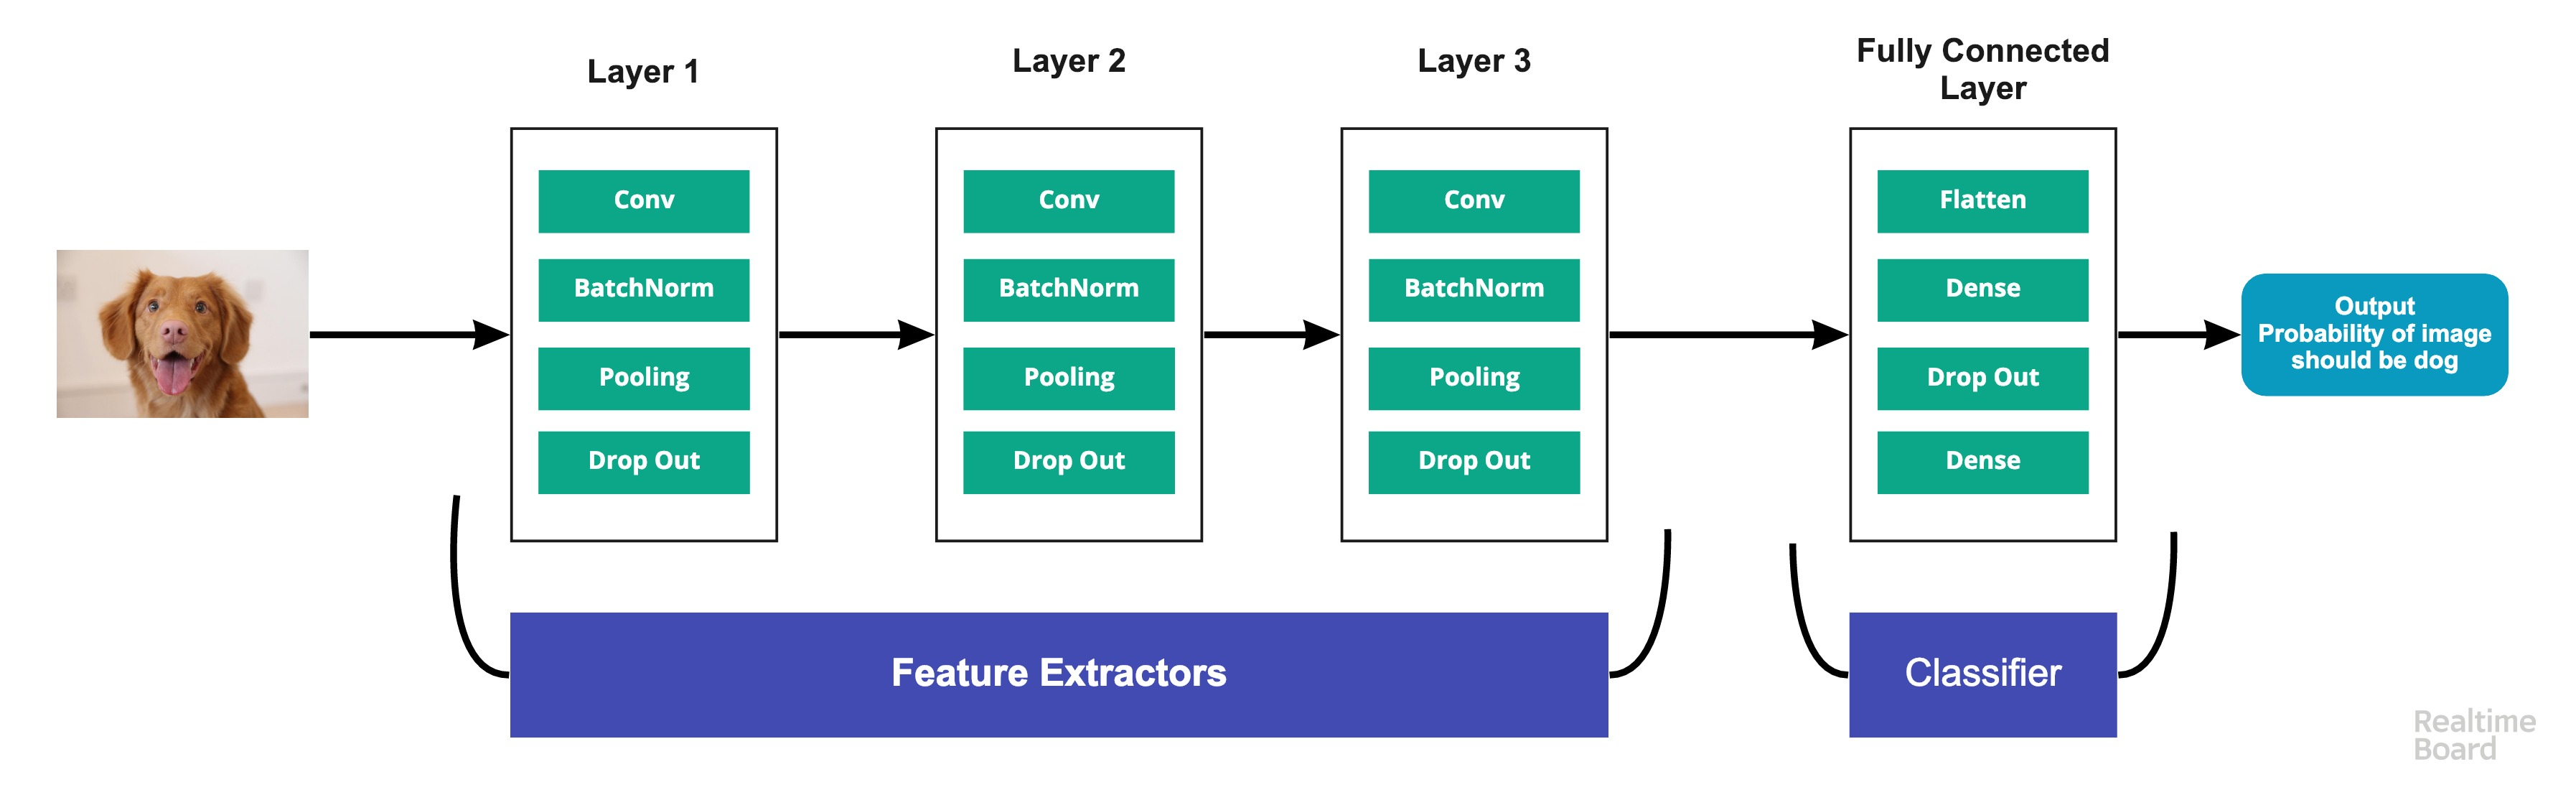

- Input Layer: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.

- Conv Layer: This layer will extract features from image.

- Pooling Layer: This layer reduce the spatial volume of input image after convolution.

- Fully Connected Layer: It connect the network from a layer to another layer

- Output Layer: It is the predicted values layer.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32,(3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

## Callbacks

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Early Stop
earlystop = EarlyStopping(patience=10)

In [ ]:
# Learning Rate Reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

## Prepare data

In [ ]:
# 원핫인코딩
df["category"] = df["category"].replace({0:'cat', 1:'dog'})

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

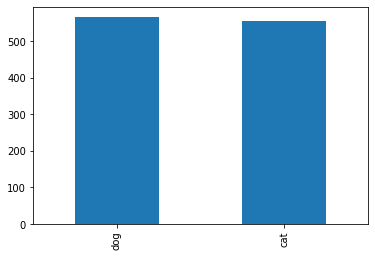

In [ ]:
train_df['category'].value_counts().plot.bar()

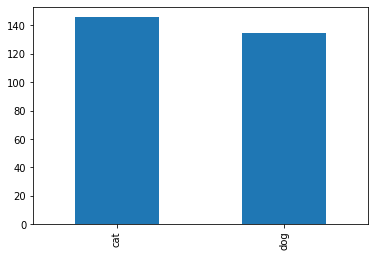

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Traning Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 15, 
    rescale = 1./255,
    shear_range = 0.1, # 이미지기울기
    zoom_range = 0.2,
    horizontal_flip = True, # 이미지가로뒤집기
    width_shift_range = 0.1, # 좌우이동
    height_shift_range = 0.1 # 상하이동
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/Data/캐글 실습 필사/train_700" ,
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 1121 validated image filenames belonging to 2 classes.


## Validation Generator

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/Data/캐글 실습 필사/train_700", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 281 validated image filenames belonging to 2 classes.


## See how our generator work

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/drive/MyDrive/Data/캐글 실습 필사/train_700", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


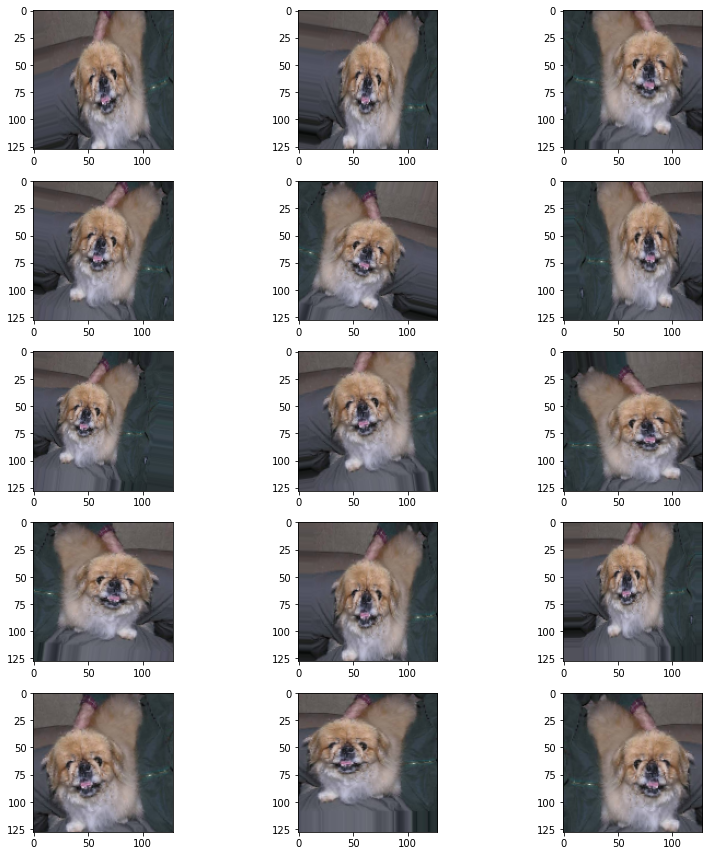

In [ ]:
plt.figure(figsize=(12, 12))

for i in range(0,15):
  plt.subplot(5,3,i+1)
  for X_batch, Y_batch in example_generator:
    image = X_batch[0]
    plt.imshow(image)
    break
plt.tight_layout()
plt.show()

## Fit Model

In [ ]:
epochs=3 if FAST_RUN else 50

history = model.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate // batch_size,
    steps_per_epoch = total_train // batch_size,
    callbacks = callbacks 
)

<ipython-input-35-0afd4a2c510c>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/3
74/74 [==============================] - ETA: 0s - loss: 1.1191 - accuracy: 0.5660

74/74 [==============================] - 257s 4s/step - loss: 1.1191 - accuracy: 0.5660 - val_loss: 0.7417 - val_accuracy: 0.5741 - lr: 0.0010
Epoch 2/3
74/74 [==============================] - ETA: 0s - loss: 0.9998 - accuracy: 0.5823

74/74 [==============================] - 86s 1s/step - loss: 0.9998 - accuracy: 0.5823 - val_loss: 0.9672 - val_accuracy: 0.5148 - lr: 0.0010
Epoch 3/3
74/74 [==============================] - ETA: 0s - loss: 0.8301 - accuracy: 0.6049

74/74 [==============================] - 74s 998ms/step - loss: 0.8301 - accuracy: 0.6049 - val_loss: 0.6795 - val_accuracy: 0.5852 - lr: 0.0010


## Save Model

In [ ]:
model.save_weights('model.h5')

## Virtualize Training

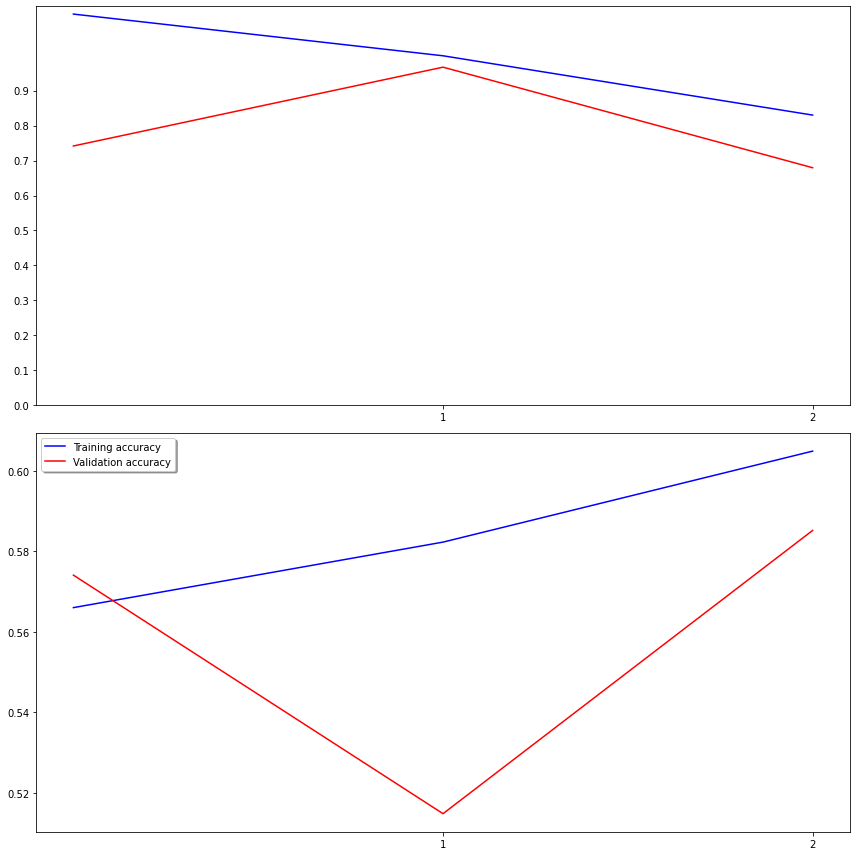

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Prepare Testing Data

In [ ]:
test_filenames = os.listdir("/content/drive/MyDrive/Data/캐글 실습 필사/test_500")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## Create Testing Generator

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "/content/drive/MyDrive/Data/캐글 실습 필사/test_500", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 500 validated image filenames.


## Predict

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-42-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

## Virtaulize Result

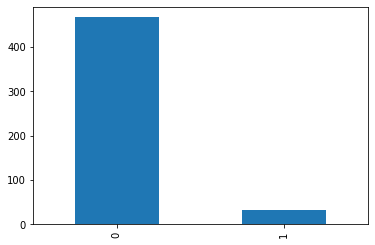

In [ ]:
test_df['category'].value_counts().plot.bar()

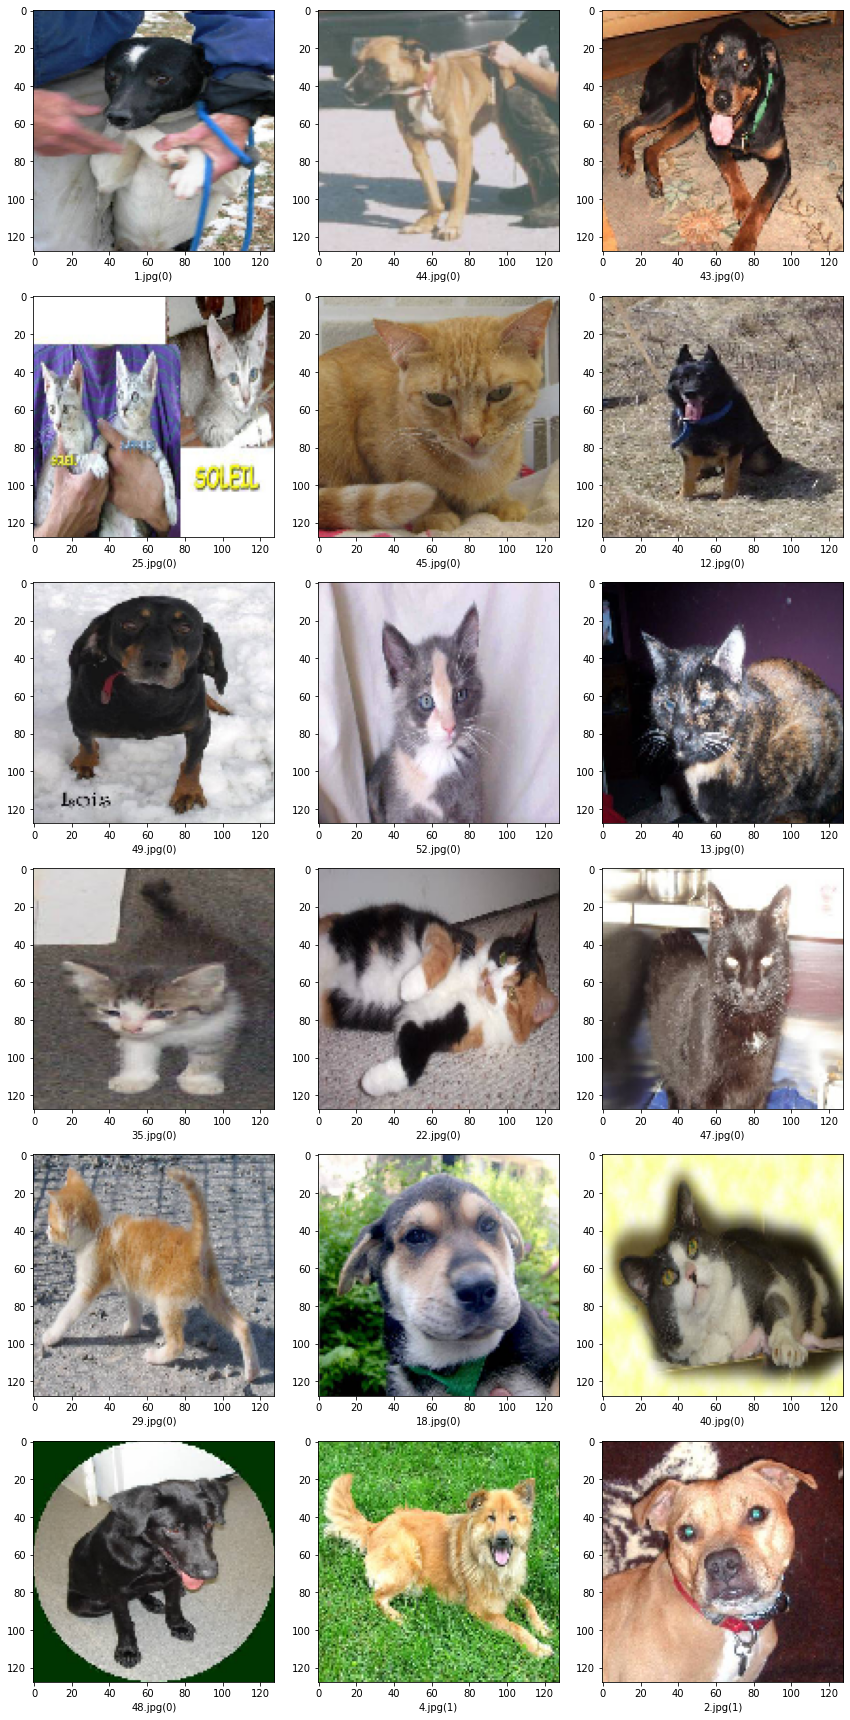

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/MyDrive/Data/캐글 실습 필사/test_500/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

## Submission

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)